In [4]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from functools import partial

In [5]:
MultivariateNormal?

<br>**Get the data to cluster**

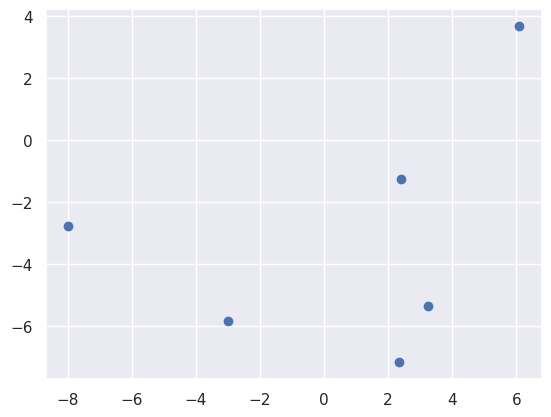

In [53]:
centers = torch.rand(6, 2)*16 - 8
plt.scatter(centers[:, 0], centers[:, 1])

In [49]:
n_samples = 1000

In [20]:
def sample(m): return MultivariateNormal(m, torch.tensor([[1, 0], [0, 1]]).float()).sample((n_samples, ))

In [54]:
points = torch.cat([sample(m) for m in centers], dim=0)

In [55]:
points.shape

torch.Size([6000, 2])

In [26]:
def plot_points(points, centers, ax=None):
    if ax == None: _, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], s=3)
    ax.scatter(centers[:, 0], centers[:, 1], marker='X', c='black', s=30)
    ax.scatter(centers[:, 0], centers[:, 1], marker='X', c='red', s=10)

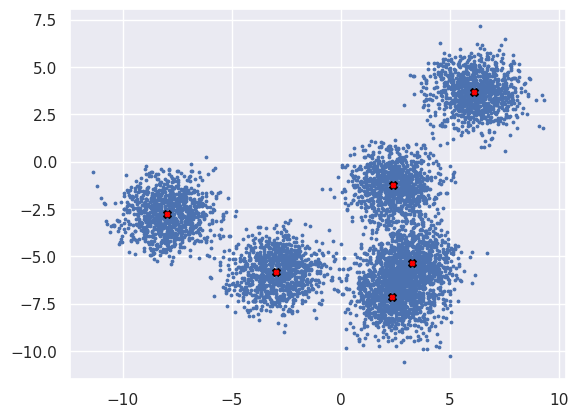

In [56]:
plot_points(points, centers)

In [28]:
def plot_func(f, l=0, r=20):
    x = torch.linspace(0, 20, 500)
    plt.plot(x, f(x))

<br> **Make the algo**

In [29]:
#def dist_point(point, points):
#    # point: (1, 2); points: (n, 2)
#    return torch.sqrt(((point - points)**2).sum(dim=1))
def dist(points):
    # points: (n, 2)
    xs = points[:, [0]]; ys = points[:, [1]]
    return torch.sqrt((torch.transpose(xs, 0, 1) - xs)**2 + (torch.transpose(ys, 0, 1) - ys)**2)
def weight_func(tens, bw=3):
    return torch.clip(1-tens/bw, min=0)

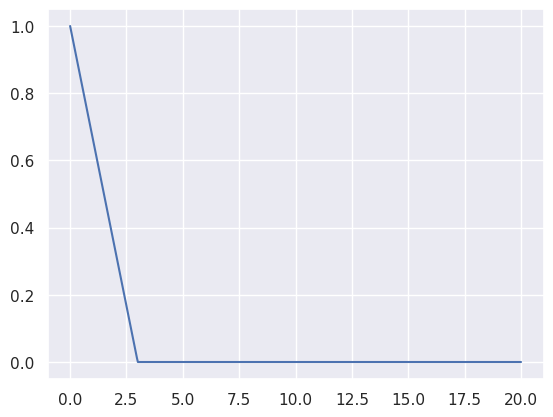

In [62]:
plot_func(partial(weight_func, bw=3))

In [31]:
#def get_weighted_mean_point(point, points):
#    weighted_dist = weight_func(dist(point, points), bw=8)
#    weighted_mean = (points*weighted_dist[:, None]).sum(dim=0)/weighted_dist.sum()
#    return weighted_mean

def get_weighted_mean(points, bw=8):
    weighted_dist = weight_func(dist(points), bw=bw)
    weighted_mean = (weighted_dist@points)/weighted_dist.sum(dim=1)[:, None]
    return weighted_mean

<br>**Get the video**

In [32]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [57]:
def one_update(d):
    global points_copy
    if d: points_copy = get_weighted_mean(points_copy, bw=2)
    ax.clear()
    plot_points(points_copy, centers+0.3, ax=ax)

In [58]:
def meanshift(it=9):
    global points_copy
    #points_copy = points.clone()
    for i in range(it):
        points_copy = get_weighted_mean(points_copy, bw=2)

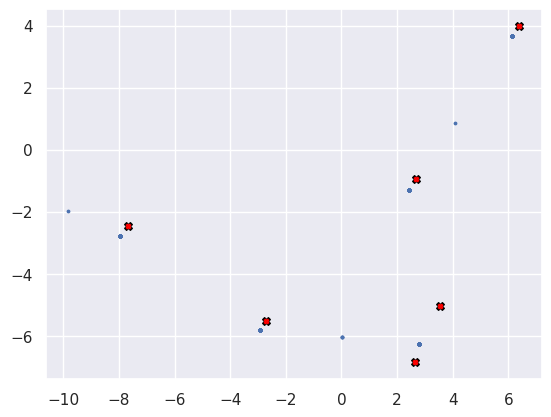

In [59]:
points_copy = points.clone()
meanshift()
plot_points(points_copy, centers+0.3)

In [60]:
points_copy = points.clone()
%timeit meanshift()

1.73 s ± 54.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
points_copy = points.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, one_update, frames=9, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

<br><br> **GPU acceleration**

In [72]:
bs = 5
points_b = points[bs:2*bs]; points_b.shape

torch.Size([5, 2])

In [74]:
def dist(points_b, points):
    # points_b: (bs, 2), points: (n, 2)
    return torch.sqrt(((points_b[:, None, :] - points)**2).sum(dim=2))
def weight_func(tens, bw=2):
    return torch.clip(1-tens/bw, min=0)

In [75]:
dist(points_b, points)[:, :5]

tensor([[0.8627, 2.1049, 0.6080, 2.5945, 2.7767],
        [1.1730, 4.0669, 2.1248, 1.0559, 2.5509],
        [3.5159, 2.2329, 2.5356, 4.0204, 2.5093],
        [0.4854, 2.5375, 0.8687, 2.3063, 2.7639],
        [2.0962, 1.2110, 1.0332, 3.2367, 2.4691]])

In [78]:
weight_func(dist(points_b, points))[:, :5]

tensor([[0.5687, 0.0000, 0.6960, 0.0000, 0.0000],
        [0.4135, 0.0000, 0.0000, 0.4720, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7573, 0.0000, 0.5657, 0.0000, 0.0000],
        [0.0000, 0.3945, 0.4834, 0.0000, 0.0000]])

In [81]:
def get_weighted_mean(points_b, points, bw=2):
    weighted_dist = weight_func(dist(points_b, points), bw=bw)
    weighted_mean = (weighted_dist@points)/weighted_dist.sum(dim=1, keepdim=True)
    return weighted_mean

In [82]:
get_weighted_mean(points_b, points)

tensor([[-8.5563, -1.9179],
        [-7.2557, -1.8887],
        [-9.3308, -3.7266],
        [-8.3077, -1.8095],
        [-9.0687, -2.6770]])

In [92]:
def meanshift(points, bs=400, it=9):
    X = points.clone()
    n = X.shape[0]
    for i in range(it):
        #for batch in range(0, X.shape[0], bs):
        #    X[batch:batch+bs] = get_weighted_mean(X[batch:batch+bs], X, bw=2.5)
        X = torch.cat([get_weighted_mean(X[batch:min(n, batch+bs)], X, bw=2.5) for batch in range(0, n, bs)], dim=0)
    return X

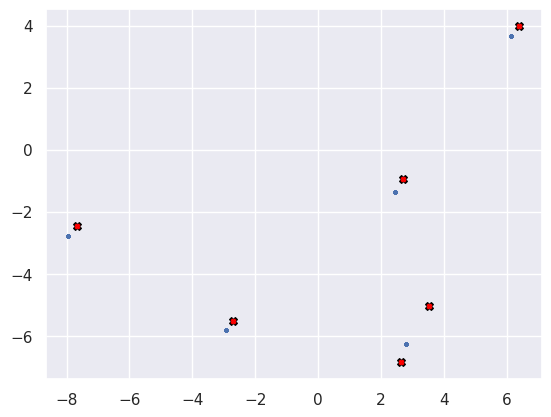

In [96]:
X = meanshift(points, bs=1024, it=7)
plot_points(X, centers+0.3)